<a href="https://colab.research.google.com/github/tonigarrett2023/FinalProject/blob/main/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import the necessary packages

import numpy as np
import tensorflow as tf

from keras.optimizers import SGD
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization, AveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import load_model
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import os
import pandas as pd
import glob
import time
import random
import cv2

In [ ]:

from google.colab import drive
drive.mount('/content/drive/')



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Final_Project/Hyperkvasir_labeled_images/upper_lower_gi_tract"

## Data preprocessing

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

train_dataset = tf.keras.utils.image_dataset_from_directory(path,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=True,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=42)

validation_dataset = tf.keras.utils.image_dataset_from_directory(path,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=True,
                                                                 validation_split=0.2,
                                                                 subset="validation",
                                                                 seed=42)

Found 10662 files belonging to 23 classes.
Using 8530 files for training.
Found 10662 files belonging to 23 classes.
Using 2132 files for validation.


## Visualising the first nine images from the training set

In [ ]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AttributeError: ignored

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 3)
validation_dataset = validation_dataset.skip(val_batches // 3)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 45
Number of test batches: 22


## Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation to help with overfitting 
 - displaying what the augmented image looks like

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.3),
  tf.keras.layers.RandomBrightness([-0.8,0.8]),
  tf.keras.layers.RandomContrast(0.2)
])

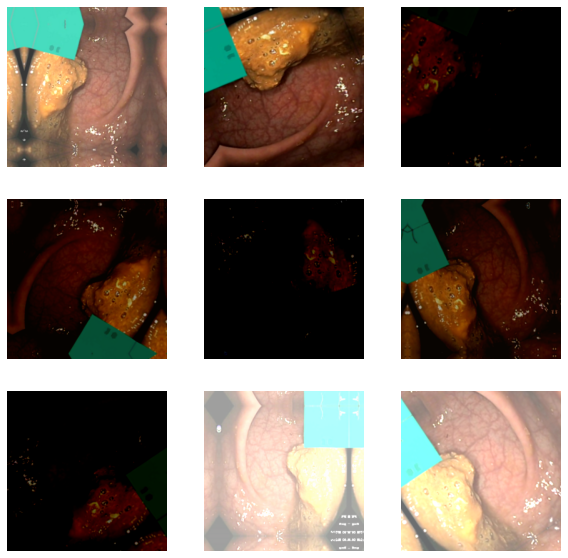

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0),training=True)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Rescaling pixel values

In [ ]:
preprocess_input_inception = tf.keras.applications.inception_v3.preprocess_input

# Inception V3

## Creating the base model from pre-trained weights
 - excludes the classification layers at the top which is ideal for feature extraction

In [ ]:
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False, 
    input_shape=(256, 256, 3))

## Freeze the base model

In [ ]:
base_model.trainable=False


## Build the model using augmented data, rescaled pixel values and the base model and feature extractor layers 

In [ ]:
model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256,256,3)),
        data_augmentation,
        tf.keras.layers.Lambda(preprocess_input_inception),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(23, activation='softmax')
    ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                      

## Compile and train the model 

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


267/267 [==============================] - 1024s 4s/step - loss: 2.2710 - accuracy: 0.3259 - val_loss: 1.4819 - val_accuracy: 0.5777
Epoch 2/10
267/267 [==============================] - 83s 308ms/step - loss: 1.6266 - accuracy: 0.5144 - val_loss: 1.1358 - val_accuracy: 0.6744
Epoch 3/10
267/267 [==============================] - 83s 308ms/step - loss: 1.3874 - accuracy: 0.5700 - val_loss: 0.9789 - val_accuracy: 0.7003
Epoch 4/10
267/267 [==============================] - 83s 307ms/step - loss: 1.2668 - accuracy: 0.5995 - val_loss: 0.9241 - val_accuracy: 0.7087
Epoch 5/10
267/267 [==============================] - 82s 305ms/step - loss: 1.2022 - accuracy: 0.6182 - val_loss: 0.8407 - val_accuracy: 0.7325
Epoch 6/10
267/267 [==============================] - 82s 303ms/step - loss: 1.1187 - accuracy: 0.6401 - val_loss: 0.8279 - val_accuracy: 0.7311
Epoch 7/10
267/267 [==============================] - 81s 302ms/step - loss: 1.0950 - accuracy: 0.6481 - val_loss: 0.7869 - val_accuracy: 0.75

## Visualise the training and validation accuracies

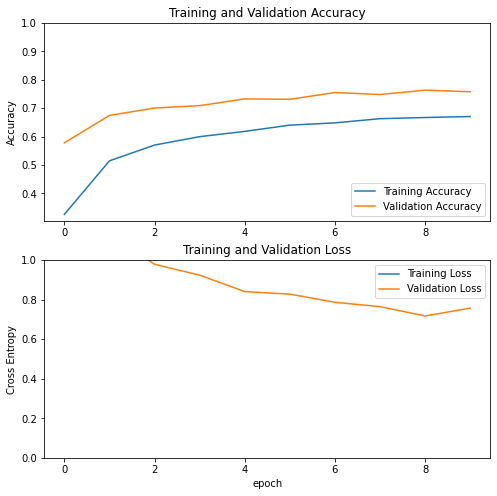

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning
 - unfreeze the base model and set the bottom layers to be untrainable

In [ ]:
base_model.trainable = True

In [ ]:
# How many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  311


## Compile and continue training the model

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

fine_tune_epochs = 40
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/50


267/267 [==============================] - 139s 414ms/step - loss: 1.2397 - accuracy: 0.6127 - val_loss: 0.6383 - val_accuracy: 0.7780
Epoch 11/50
267/267 [==============================] - 110s 408ms/step - loss: 0.9159 - accuracy: 0.6987 - val_loss: 0.5276 - val_accuracy: 0.8200
Epoch 12/50
267/267 [==============================] - 109s 405ms/step - loss: 0.8034 - accuracy: 0.7327 - val_loss: 0.4956 - val_accuracy: 0.8305
Epoch 13/50
267/267 [==============================] - 108s 403ms/step - loss: 0.7310 - accuracy: 0.7584 - val_loss: 0.4522 - val_accuracy: 0.8438
Epoch 14/50
267/267 [==============================] - 108s 403ms/step - loss: 0.6736 - accuracy: 0.7751 - val_loss: 0.4236 - val_accuracy: 0.8529
Epoch 15/50
267/267 [==============================] - 108s 402ms/step - loss: 0.6478 - accuracy: 0.7859 - val_loss: 0.4069 - val_accuracy: 0.8599
Epoch 16/50
267/267 [==============================] - 108s 404ms/step - loss: 0.6218 - accuracy: 0.7940 - val_loss: 0.3946 - val_

## Visualise the performance after some fine-tuning

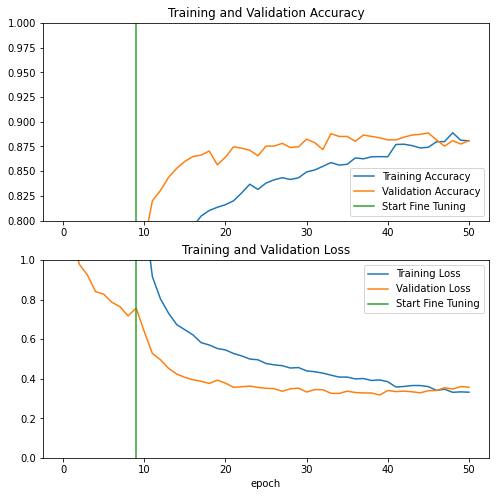

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and Prediction

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

22/22 [==============================] - 3s 90ms/step - loss: 0.3993 - accuracy: 0.8722
Test accuracy : 0.8721590638160706


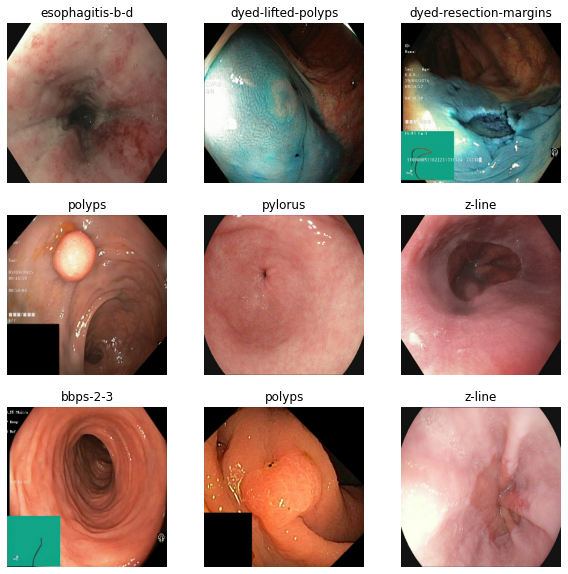

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
prediction = model.predict_on_batch(image_batch)

predictions = []

# Last layer of model is softmax: take the maximum to predict
for arr in prediction:
  predictions.append(np.argmax(arr))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
model.save('/content/drive/MyDrive/Final_Project/Models/InceptionV3_model1.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Final_Project/Models/ResNet50_model1.h5')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, matthews_corrcoef, roc_auc_score

## Evaluation and Prediction

In [ ]:
# Define the path to the directory containing the subdirectories for each class

# Get the names of the subdirectories, which correspond to the class names
class_names = os.listdir(path)
labels = os.listdir(path)

# Sort the class names alphabetically (optional)
class_names.sort()
labels.sort()

# Print the class names
print(class_names)
print(labels)

['barretts', 'barretts-short-segment', 'bbps-0-1', 'bbps-2-3', 'cecum', 'dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis-a', 'esophagitis-b-d', 'hemorrhoids', 'ileum', 'impacted-stool', 'polyps', 'pylorus', 'retroflex-rectum', 'retroflex-stomach', 'ulcerative-colitis-grade-0-1', 'ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-2', 'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-3', 'z-line']
['barretts', 'barretts-short-segment', 'bbps-0-1', 'bbps-2-3', 'cecum', 'dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis-a', 'esophagitis-b-d', 'hemorrhoids', 'ileum', 'impacted-stool', 'polyps', 'pylorus', 'retroflex-rectum', 'retroflex-stomach', 'ulcerative-colitis-grade-0-1', 'ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-2', 'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-3', 'z-line']


In [ ]:
unique_labels, _ = tf.unique(tf.concat([labels for _, labels in validation_dataset], axis=0))
print("Number of unique classes in validation dataset:", len(unique_labels))
print(unique_labels.numpy())


# unique_labels = set()

# for images, labels in validation_dataset:
#     unique_labels.update(np.unique(labels))
    
# print("Number of unique classes in validation dataset:", len(unique_labels))
# print(unique_labels)


class_names = ['ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-3', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-0-1',
               'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-2', 'dyed-resection-margins', 'dyed-lifted-polyps',
               'hemorrhoids', 'polyps', 'retroflex-rectum', 'bbps-0-1', 'barretts-short-segment', 'cecum',
               'esophagitis-b-d', 'ileum', 'barretts', 'bbps-2-3', 'esophagitis-a', 'impacted-stool', 'pylorus',
               'z-line', 'retroflex-stomach']




Number of unique classes in validation dataset: 21
[22  5  3  2 12 13  6 21  4 14 15 19  7 17 11  8  1  0 10 20 16]


In [ ]:


# Get the predictions for the validation set
y_pred = model.predict(validation_dataset)

# Convert the predictions from probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels for the validation set
y_true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)

# Create the classification report
report = classification_report(y_true_labels, y_pred_labels, labels=unique_labels, target_names=class_names)

# Print the confusion matrix and classification report
print('Confusion Matrix:\n', confusion_matrix(y_true_labels, y_pred_labels))
print('Classification Report:\n', report)


45/45 [==============================] - 6s 88ms/step
Confusion Matrix:
 [[ 0  0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  1  0  1  0  0  0  0  0  1  0  0  2  0  0  0  0  0  0]
 [ 0  0  1  8  7  3  7  4  1  0  1  7  8  1  6  0  2  4  0  1 11]
 [ 0  0  7 24 11 12 15  5  6  0  2  7 16  6 14  0  6  6  0  1 19]
 [ 0  0  5  8 15 12  7  7  7  0  1 17 17  2 11  0  4  9  0  1 13]
 [ 0  0  9 13  9 12 16  4  6  0  0 10 17  5 10  0  3  4  0  2 11]
 [ 0  0 12 12 14 20  9  5  4  0  2 12 14  6  8  0  0  6  0  0 10]
 [ 0  0  2  7  5  5  9  3  0  0  1  5 11  2  2  0  0  2  0  0  5]
 [ 0  0  1  6  6  3  3  1  2  0  0  4  5  2  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  1  0  2  4  0  0  0  0  3  2  1  1  0  0  2  0  0  4]
 [ 0  0 10 24 11 11 12  3  3  0  0 12 13  8  9  0  1 10  0  0  8]
 [ 0  0  9 13 11 17  9  6  1  0  2 13 20  8  5  0  3 13  0  2 17]
 [ 0  0  4  6  6  6  2  1  2  0  1  6  2  3  4  0  0  2  0  0  8]
 [ 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 21, does not match size of target_names, 23
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

In [ ]:
# Get the predictions for the testing set
y_pred = model.predict(test_dataset)

# Convert the predictions from probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels for the validation set
y_true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Create the classification report
report = classification_report(y_true_labels, y_pred_labels, labels=unique_labels, target_names=class_names)

# Print the confusion matrix and classification report
print('Confusion Matrix:\n', confusion_matrix(y_true_labels, y_pred_labels))
print('Classification Report:\n', report)

22/22 [==============================] - 3s 90ms/step
Confusion Matrix:
 [[ 0  0  0  1  0  1  1  0  0  0  0  1  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  1  0]
 [ 0  0  3  5  5  6  5  3  0  1  0  5  2  3  0  2  0  4  0  0  2]
 [ 0  0  3  7  9  6  5  4  3  1 13  6  2  5  0  1  0  1  0  2 12]
 [ 0  0  1  7  4  6  3  4  1  2  9  3  1  4  0  3  0  4  0  1  5]
 [ 0  0  6  8  4  8  5  1  2  2  8  3  4  2  0  2  0  9  0  0  7]
 [ 0  0  4  8  6  6  1  2  1  0  6  5  2  5  0  2  0  2  0  0  3]
 [ 0  0  2  1  0  3  2  2  0  0  4  1  0  1  0  2  0  2  0  0  1]
 [ 0  0  0  1  0  1  1  0  0  0  2  4  0  0  0  0  0  3  0  0  3]
 [ 0  0  0  2  0  0  1  0  1  0  2  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  5  7  7  4  5  1  2  1 10  8  1  2  0  2  0  6  0  0  4]
 [ 0  0  4  5  6  9  6  3  2  0  6  8  1  6  0  1  0  3  0  0  9]
 [ 0  0  1  1  3  4  0  2  1  0  0  3  0  4  0  0  0  0  0  0  2]
 [ 0  0  6  4  3  1  3  2  2  0  3 10  2  3  0  0  0  3  0  1 10]
 [ 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 21, does not match size of target_names, 23
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

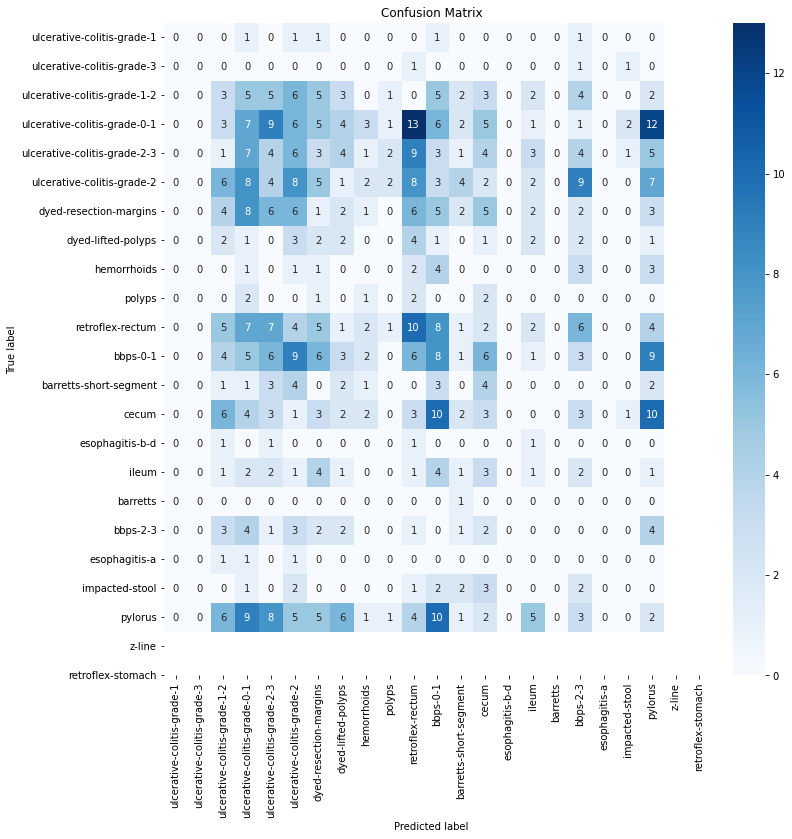

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Print the confusion matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

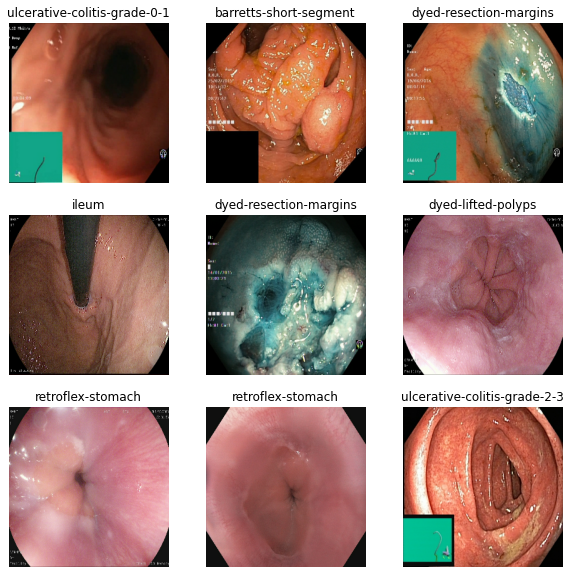

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
prediction = model.predict_on_batch(image_batch)

predictions = []

# Last layer of model is softmax: take the maximum to predict
for arr in prediction:
  predictions.append(np.argmax(arr))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

1/1 [==============================] - 0s 42ms/step


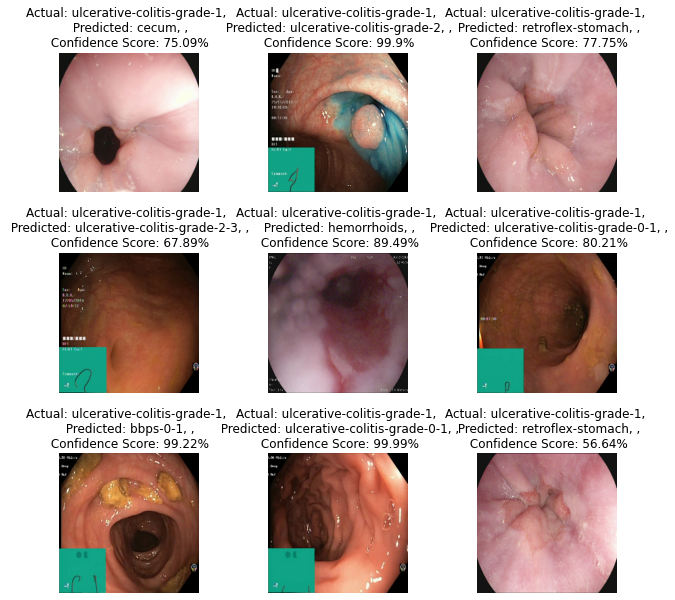

In [ ]:
# Create a figure with subplots for each image
plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.4)

for images, labels in validation_dataset.take(1):
    for i in range(9):
        # Get the image and label data
        image = images[i].numpy().astype('uint8')
        label = labels[i]
        
        # Reshape the label tensor to have a shape of (1,)
        label = tf.reshape(label, (1,))
        
        # Get the actual and predicted class names
        actual_cls = class_names[tf.argmax(label).numpy()]
        prediction = model.predict(images)
        predicted_cls = class_names[np.argmax(prediction[i])]
        confidence = round(100 * (np.max(prediction[i])), 2)
        
        
        # Plot the image and label data
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Actual: {actual_cls}, \n Predicted: {predicted_cls}, ,\n Confidence Score: {confidence}%")
        plt.axis("off")
plt.show()

